In [215]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [216]:
image = cv2.imread('Summer Farewell.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512,512))
image = image.astype(np.float128)

In [217]:
reconstructed_img_norequant = np.zeros_like(image)
reconstructed_img_lossy = np.zeros_like(image)
reconstructed_img_lossless = np.zeros_like(image)

In [218]:
reconstructed_img_classical_norequant = np.zeros_like(image)
reconstructed_img_classical_lossy = np.zeros_like(image)
reconstructed_img_classical_lossless = np.zeros_like(image)

In [219]:
def classical_dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def classical_idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [220]:
def DCT_mat(N):
    Mat = np.zeros((N, N))
    for k in range(N):
        for n in range (N):
            alpha = np.sqrt(1/N) if k == 0 else np.sqrt(2/N)
            Mat[k,n] = alpha * np.cos(np.pi * (n + 0.5) * k / N)
    return Mat

In [221]:
def safe_psnr(original, reconstructed, data_range=255):
    original = original.astype(np.float64)
    reconstructed = reconstructed.astype(np.float64)
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    else:
        return 10 * np.log10((data_range ** 2) / mse)


In [222]:
def normalize_img_for_display(img, minval=0, maxval=255):
    img_min, img_max = np.min(img), np.max(img)
    if img_max == img_min:
        return np.zeros_like(img)
    return ((img - img_min) / (img_max - img_min)) * (maxval - minval) + minval

In [223]:
def compute_metrics(original, resconstructions, psnr_plot_value=60):
    result = []
    original_int32 = original.astype(np.uint32)
    for name, imgs in resconstructions.items():
        if name == "Original":
            continue

        img_int32 = imgs.astype(np.uint32)
        psnr_val = safe_psnr(original_int32, img_int32, data_range=255)

        if np.isinf(psnr_val):
            psnr_plot = psnr_plot_value
            psnr_val = psnr_plot_value
        else:
            psnr_plot = psnr_val

        min_size = min(original_int32.shape[0], original_int32.shape[1])
        ssim_win_size = min(7, min_size)
        if ssim_win_size % 2 == 0:
            ssim_win_size -= 1
        if ssim_win_size < 3:
            ssim_win_size = 3
        ssim_val = ssim(original_int32, img_int32, data_range=255, win_size=ssim_win_size)
        nonzero_ori = np.count_nonzero(original_int32)
        nonzero_recons = np.count_nonzero(img_int32)
        compression_ratio = nonzero_ori / nonzero_recons if nonzero_recons != 0 else 0
        result.append({
            "Image": name,
            "PSNR": psnr_val,
            "PSNR_plot": psnr_plot,
            "SSIM": ssim_val,
            "Compression Ratio": compression_ratio
        })

    return pd.DataFrame(result)

In [224]:
DCT8x8 = DCT_mat(64)

In [225]:
IDCT8x8 = DCT8x8.T

In [226]:
quantization_mat = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]]
    , dtype=np.float128)

In [227]:
# QDCT (Statevector/Operator simulation)
for i in range(0, 512, 8):
    for j in range(0, 512, 8):
        block = image[i:i+8, j:j+8]
        flat_block = block.flatten()
        norm_block = flat_block / np.linalg.norm(flat_block)

        state_vector = Statevector(norm_block)
        qdct_out = state_vector.evolve(Operator(DCT8x8)).data
        qdct_2d = np.real(qdct_out).reshape(8, 8)

        quantization_mat_lossy = quantization_mat / (100)
        recons_norequant = qdct_2d.copy()
        lossless_quant = qdct_2d / quantization_mat
        lossy_quant = np.round(qdct_2d / quantization_mat_lossy)
        lossless_recons = lossless_quant * quantization_mat
        lossy_recons = lossy_quant * quantization_mat_lossy

        for recons, out_img, label in zip(
            [recons_norequant, lossy_recons, lossless_recons],
            [reconstructed_img_norequant, reconstructed_img_lossy, reconstructed_img_lossless],
            ['norequant', 'lossy', 'lossless']
        ):
            if np.allclose(recons, 0):
                print(f"All-zero block at ({i},{j}) in QDCT-{label} (statevector):\n", recons)
            flat_dequant = recons.flatten()
            norm_dequant = np.linalg.norm(flat_dequant)
            norm_dequant = flat_dequant if norm_dequant == 0 else flat_dequant / norm_dequant

            sv_recons = Statevector(norm_dequant)
            idct_out = sv_recons.evolve(Operator(IDCT8x8)).data
            recons_block = np.real(idct_out).reshape(8, 8)

            min_val = recons_block.min()
            max_val = recons_block.max()
            scaled_val = 255 * (recons_block - min_val) / (max_val - min_val + 1e-8)
            out_img[i:i+8, j:j+8] = np.clip(scaled_val, 0, 255)

In [228]:
# Classical DCT
for i in range(0, 512, 8):
    for j in range(0, 512, 8):
        block = image[i:i+8, j:j+8]
        cdct = classical_dct2(block)
        classical_recons_norequant = classical_idct2(cdct)
        classical_quant_lossless = cdct / quantization_mat
        classical_quant_lossy = np.round(cdct / quantization_mat)

        classical_lossless_recons = classical_idct2(classical_quant_lossless * quantization_mat)
        classical_lossy_recons = classical_idct2(classical_quant_lossy * quantization_mat)

        for recons, out_img in zip(
            [classical_recons_norequant, classical_lossless_recons, classical_lossy_recons],
            [reconstructed_img_classical_norequant, reconstructed_img_classical_lossless, reconstructed_img_classical_lossy]
        ):
            min_val = recons.min()
            max_val = recons.max()
            scaled_val = 255 * (recons - min_val) / (max_val - min_val + 1e-8)
            out_img[i:i+8, j:j+8] = np.clip(scaled_val, 0, 255)

In [229]:
reconstructed_imgs = [image,
                      reconstructed_img_norequant, 
                      reconstructed_img_lossless,
                      reconstructed_img_lossy,
                      reconstructed_img_classical_norequant, 
                      reconstructed_img_classical_lossless, 
                      reconstructed_img_classical_lossy]

result_imgs = [img.astype(np.uint8) for img in reconstructed_imgs]

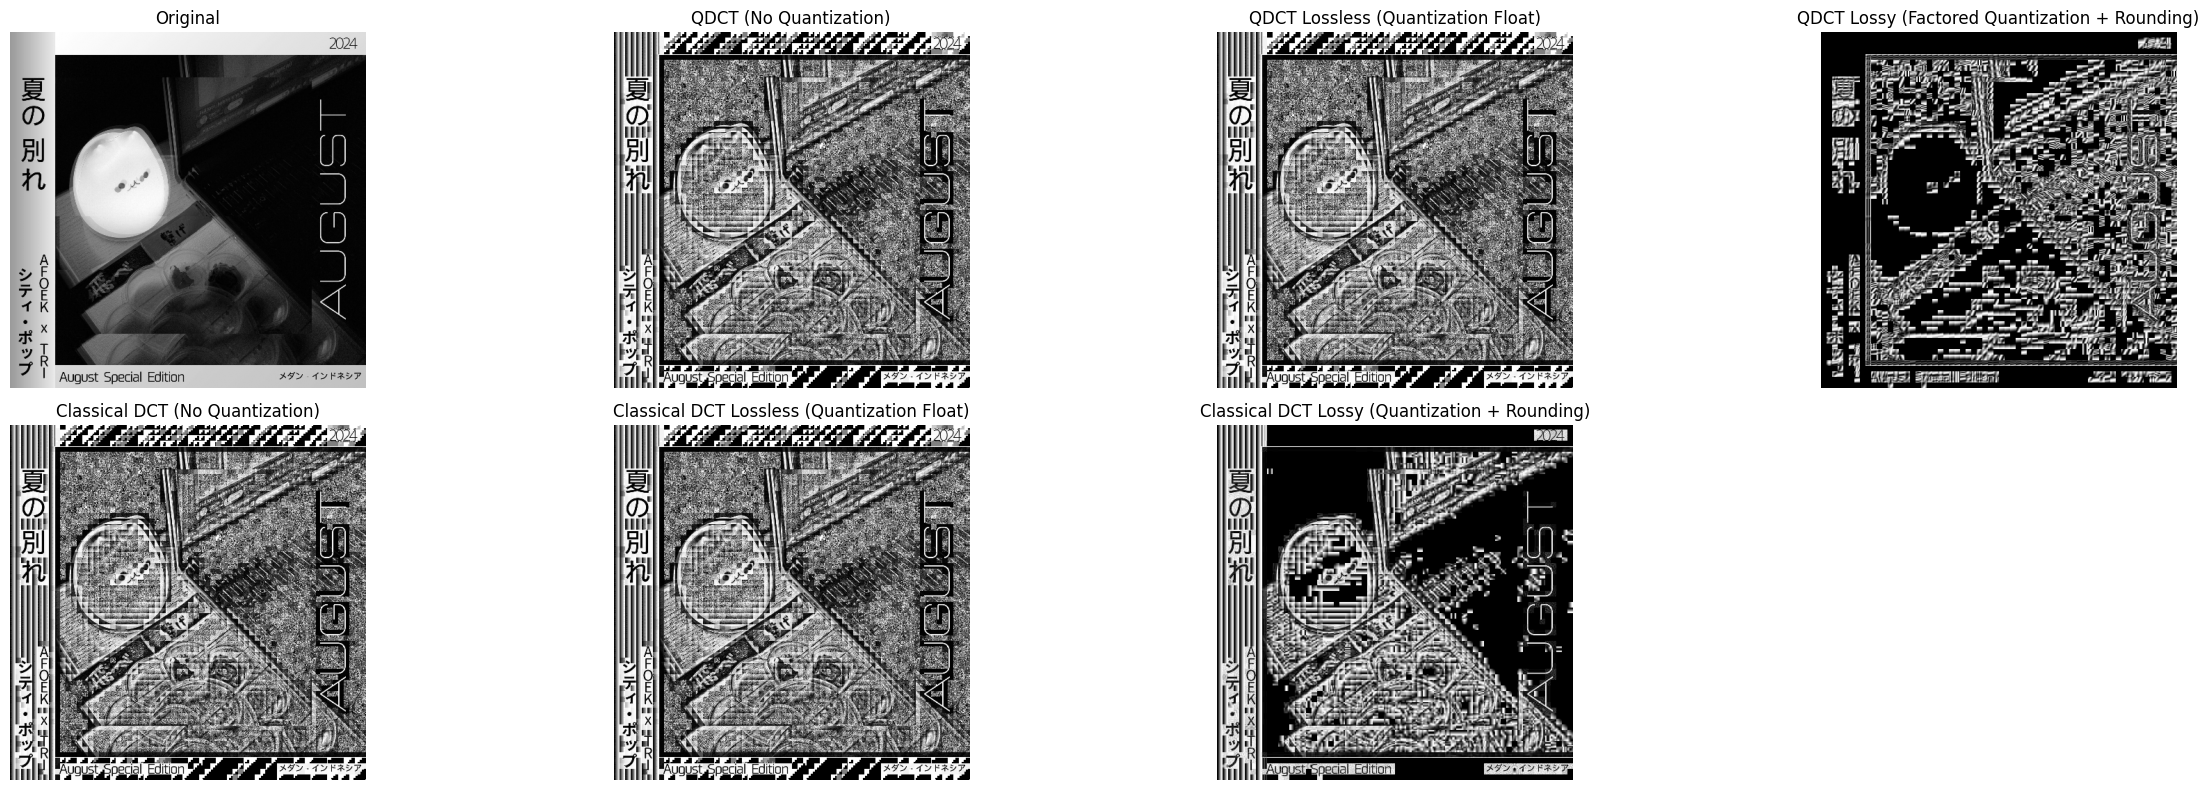

In [230]:
titles = [
    "Original",
    "QDCT (No Quantization)",
    "QDCT Lossless (Quantization Float)",
    "QDCT Lossy (Factored Quantization + Rounding)",
    "Classical DCT (No Quantization)",
    "Classical DCT Lossless (Quantization Float)",
    "Classical DCT Lossy (Quantization + Rounding)"
]

plt.figure(figsize=(25, 8))
for idx, (title, img) in enumerate(zip(titles, result_imgs)):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.savefig("figure1.png", dpi=600, bbox_inches = 'tight')
plt.show()

In [231]:
images_dict = {
    "Original": result_imgs[0],
    "QDCT (No Quantization)": result_imgs[1],
    "QDCT Lossless (Quantization Float)": result_imgs[2],
    "QDCT Lossy (Factored Quantization + Rounding)": result_imgs[3],
    "Classical DCT (No Quantization)": result_imgs[4],
    "Classical DCT Lossless (Quantization Float)": result_imgs[5],
    "Classical DCT Lossy (Quantization + Rounding)": result_imgs[6]
}

In [232]:
label_map = {
    "QDCT (No Quantization)": "QDCT - No Quant",
    "QDCT Lossless (Quantization Float)": "QDCT - Lossless",
    "QDCT Lossy (Factored Quantization + Rounding)": "QDCT - Lossy (Factored)",
    "Classical DCT (No Quantization)": "CDCT - No Quant",
    "Classical DCT Lossless (Quantization Float)": "CDCT - Lossless",
    "Classical DCT Lossy (Quantization + Rounding)": "CDCT - Lossy"
}

In [233]:
metrics_df8x8 = compute_metrics(images_dict["Original"], images_dict)
metrics_df8x8["Label"] = metrics_df8x8["Image"].map(label_map)
print(metrics_df8x8)

                                           Image      PSNR  PSNR_plot  \
0                         QDCT (No Quantization)  7.946948   7.946948   
1             QDCT Lossless (Quantization Float)  7.946948   7.946948   
2  QDCT Lossy (Factored Quantization + Rounding)  5.675853   5.675853   
3                Classical DCT (No Quantization)  7.946948   7.946948   
4    Classical DCT Lossless (Quantization Float)  7.946948   7.946948   
5  Classical DCT Lossy (Quantization + Rounding)  8.024458   8.024458   

       SSIM  Compression Ratio                    Label  
0  0.170360           1.092166          QDCT - No Quant  
1  0.170360           1.092166          QDCT - Lossless  
2  0.066131           1.836349  QDCT - Lossy (Factored)  
3  0.170360           1.092166          CDCT - No Quant  
4  0.170360           1.092166          CDCT - Lossless  
5  0.208759           1.574378             CDCT - Lossy  


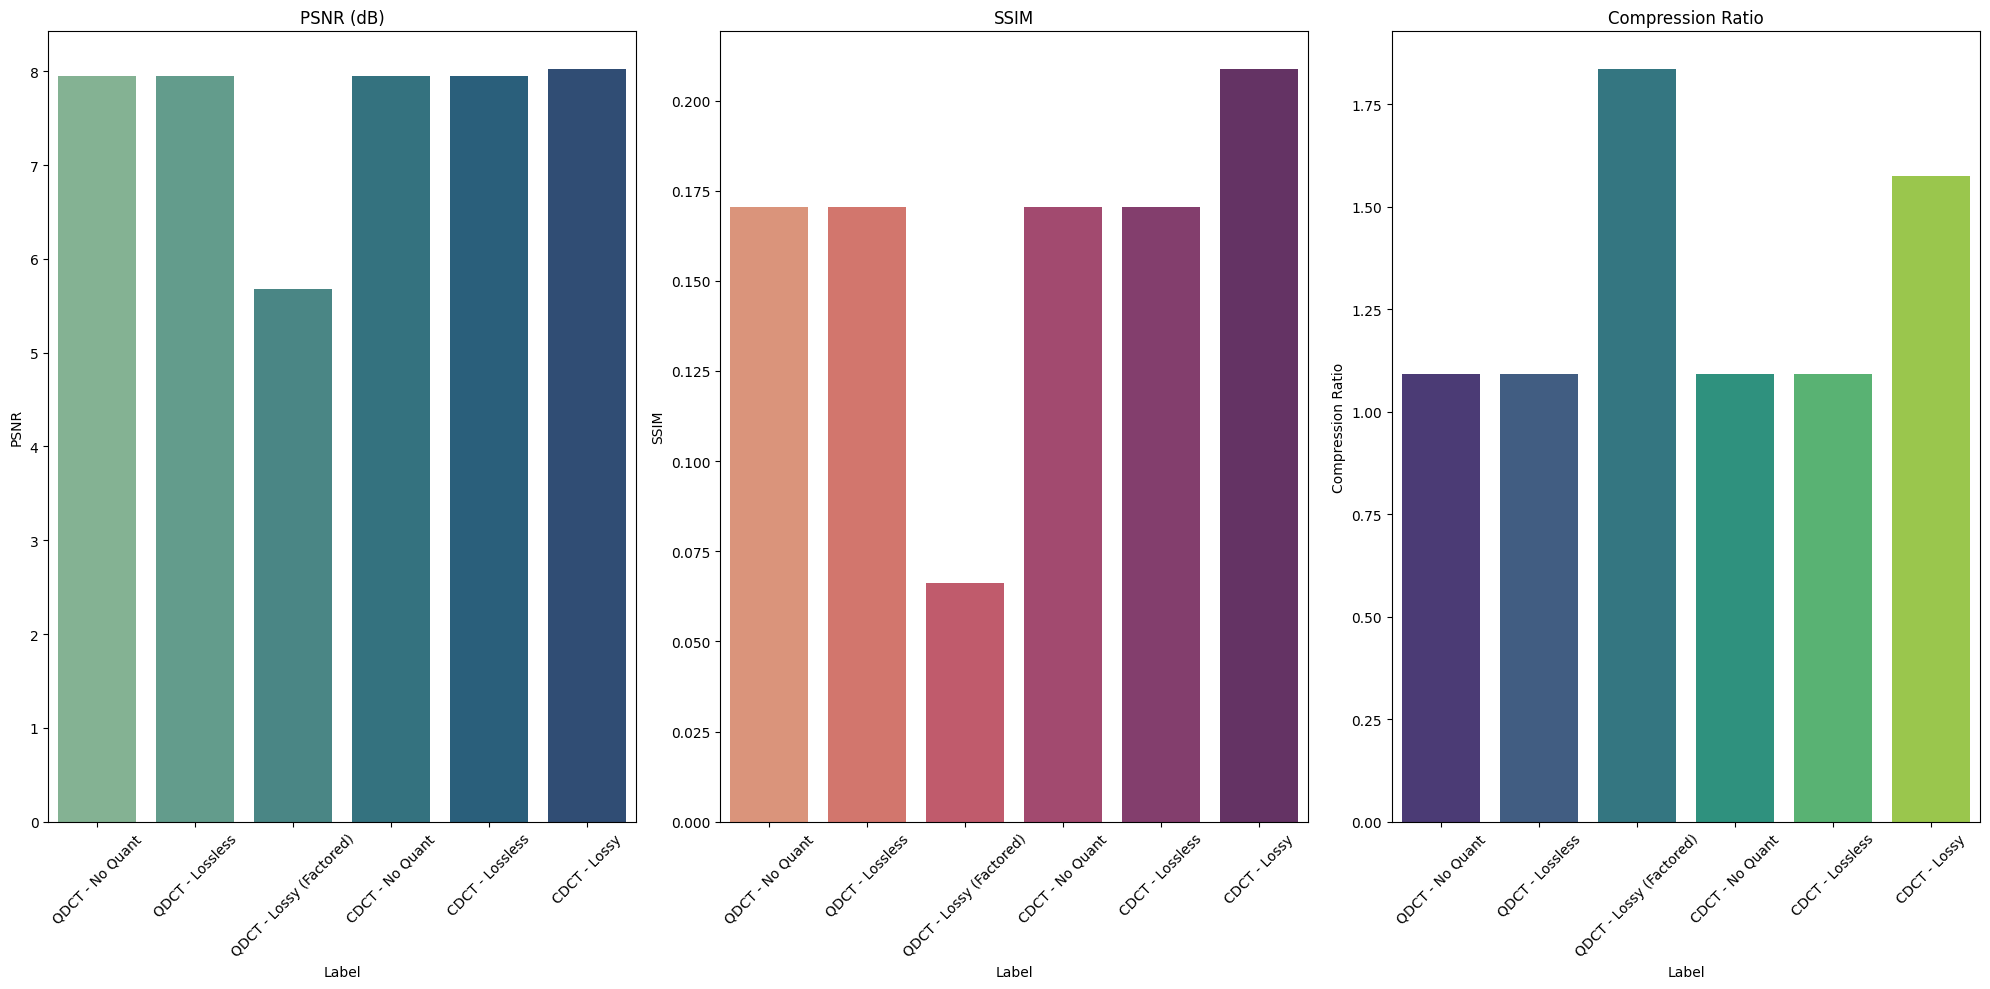

In [234]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.barplot(data=metrics_df8x8, x="Label", y="PSNR", hue="Label", palette="crest", legend=False)
plt.xticks(rotation=45)
plt.title("PSNR (dB)")

plt.subplot(1, 3, 2)
sns.barplot(data=metrics_df8x8, x="Label", y="SSIM", hue="Label", palette="flare", legend=False)
plt.xticks(rotation=45)
plt.title("SSIM")

plt.subplot(1, 3, 3)
sns.barplot(data=metrics_df8x8, x="Label", y="Compression Ratio", hue="Label", palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.title("Compression Ratio")

plt.tight_layout()
plt.show()


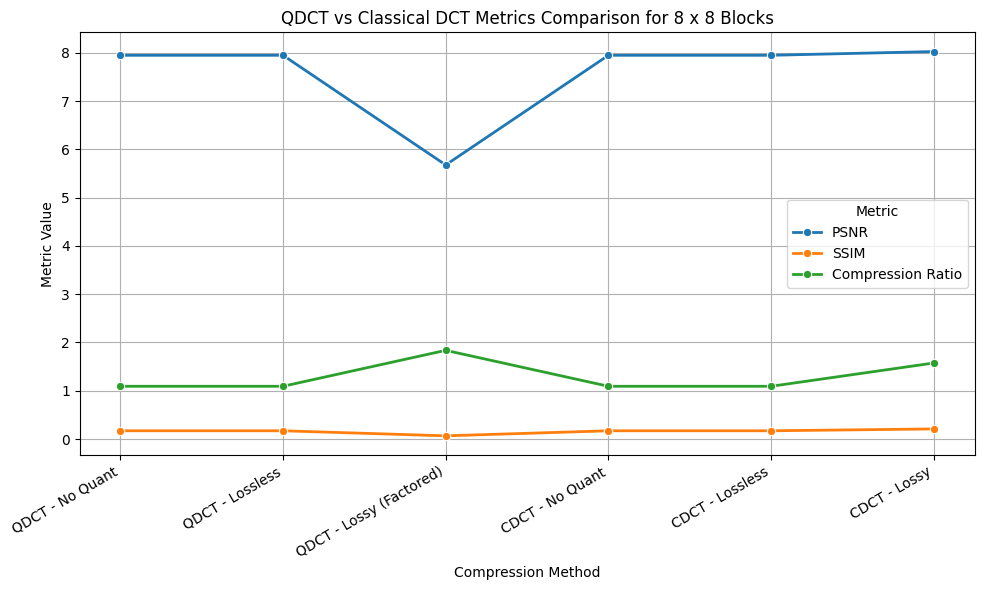

In [235]:
melted = metrics_df8x8.melt(id_vars="Label", 
                         value_vars=["PSNR", "SSIM", "Compression Ratio"],
                         var_name="Metric", 
                         value_name="Value")

plt.figure(figsize=(10, 6))
sns.lineplot(data=melted, x="Label", y="Value", hue="Metric", marker="o", linewidth=2)
plt.xticks(rotation=30, ha='right')
plt.title("QDCT vs Classical DCT Metrics Comparison for 8 x 8 Blocks")
plt.ylabel("Metric Value")
plt.xlabel("Compression Method")
plt.grid(True)
plt.tight_layout()
plt.show()


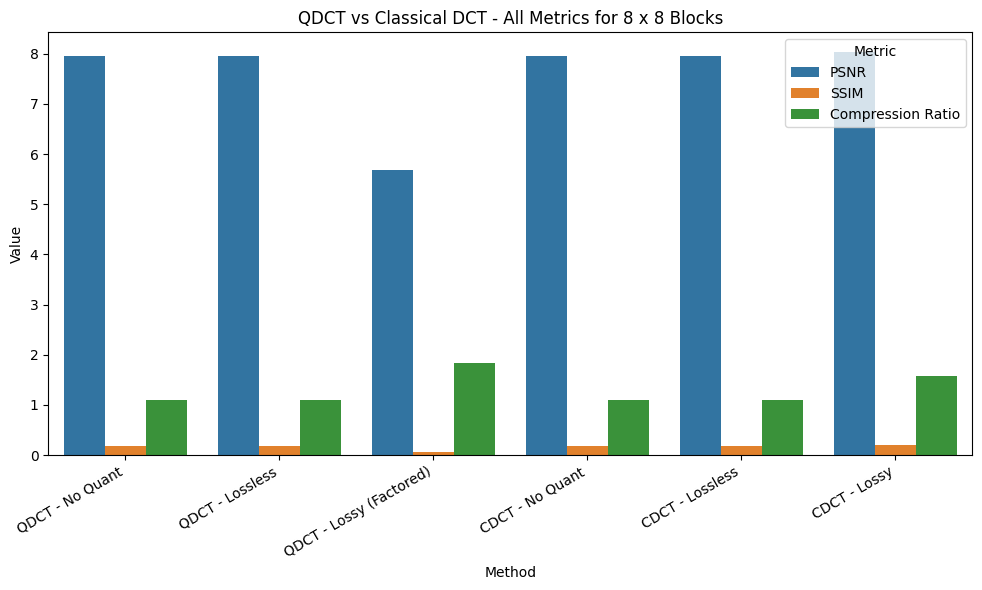

In [236]:
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Label", y="Value", hue="Metric")
plt.xticks(rotation=30, ha='right')
plt.title("QDCT vs Classical DCT - All Metrics for 8 x 8 Blocks")
plt.xlabel("Method")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [237]:
np.random.seed(42)
block_size = 4
height, width = image.shape

max_tries = 100
for _ in range(max_tries):
    i = np.random.randint(0, height - block_size + 1)
    j = np.random.randint(0, width - block_size + 1)
    img_block_sm = image[i:i+block_size, j:j+block_size].astype(np.float128)
    if np.unique(img_block_sm).size > 1:
        break

flat_block_sm = img_block_sm.flatten()

In [238]:
quantization_mat_sm = np.array([
    [16, 11, 10, 16],
    [12, 12, 14, 19],
    [14, 13, 16, 24],
    [14, 17, 22, 29]
])

In [239]:
small_dct_block = classical_dct2(img_block_sm)
recons_norequant_sm = classical_idct2(small_dct_block)

dct_lossless_sm = small_dct_block / quantization_mat_sm
recons_dct_lossless_sm = classical_idct2(dct_lossless_sm * quantization_mat_sm)

dct_lossy_sm = np.round(small_dct_block / quantization_mat_sm)
recons_dct_lossy_sm = dct_lossy_sm * quantization_mat_sm

In [240]:
norm_flat_block = flat_block_sm / np.linalg.norm(flat_block_sm)

In [241]:
DCT4x4 = DCT_mat(4)
DCT16 = np.kron(DCT4x4, DCT4x4)

In [242]:
#QDCT (state vector)
qdct_sv_sm = Statevector(norm_flat_block).evolve(Operator(DCT16)).data
qdct_sv_block = np.real(qdct_sv_sm).reshape(4, 4)

recons_qdct_sv_norequant = Statevector(qdct_sv_sm).evolve(Operator(DCT16.conj().T)).data
recons_qdct_sv_norequant = np.real(recons_qdct_sv_norequant).reshape(4, 4)

qdct_sv_lossless_sm = qdct_sv_block / quantization_mat_sm
flat_lossless = qdct_sv_lossless_sm.flatten()
norm_lossless = np.linalg.norm(flat_lossless)
if norm_lossless == 0:
    normed_flat_lossless = np.zeros_like(flat_lossless)
    normed_flat_lossless[0] = 1.0
else:
    normed_flat_lossless = flat_lossless / norm_lossless
recons_qdct_sv_lossless = Statevector(normed_flat_lossless).evolve(Operator(DCT16.conj().T)).data
recons_qdct_sv_lossless = np.real(recons_qdct_sv_lossless).reshape(4, 4)

quantization_lossy_mat_sm = quantization_mat_sm / (100.0)
qdct_sv_lossy_sm = np.round(qdct_sv_block / quantization_lossy_mat_sm)
flat_lossy = qdct_sv_lossy_sm.flatten()
norm_lossy = np.linalg.norm(flat_lossy)
if norm_lossy == 0:
    normed_flat_lossy = np.zeros_like(flat_lossy)
    normed_flat_lossy[0] = 1.0
else:
    normed_flat_lossy = flat_lossy / norm_lossy

recons_qdct_sv_lossy = Statevector(normed_flat_lossy).evolve(DCT16.conj().T).data
recons_qdct_sv_lossy = np.real(recons_qdct_sv_lossy).reshape(4, 4)


In [243]:
titles = [
    "Original",
    "Classical DCT (No Quantization)", "Classical DCT Lossless", "Classical DCT Lossy",
    "QDCT Statevector (No Quantization)", "QDCT Statevector Lossless", "QDCT Statevector Lossy",
]

result_imgs = [
    img_block_sm,
    recons_norequant_sm, recons_dct_lossless_sm, recons_dct_lossy_sm, 
    recons_qdct_sv_norequant, recons_qdct_sv_lossless, recons_qdct_sv_lossy, 
]


In [244]:
result_imgs_disp = [normalize_img_for_display(img) for img in result_imgs]

/tmp/ipykernel_173070/3087464728.py:8: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig("figure2.png", dpi=600, bbox_inches = 'tight')
/home/afoek/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


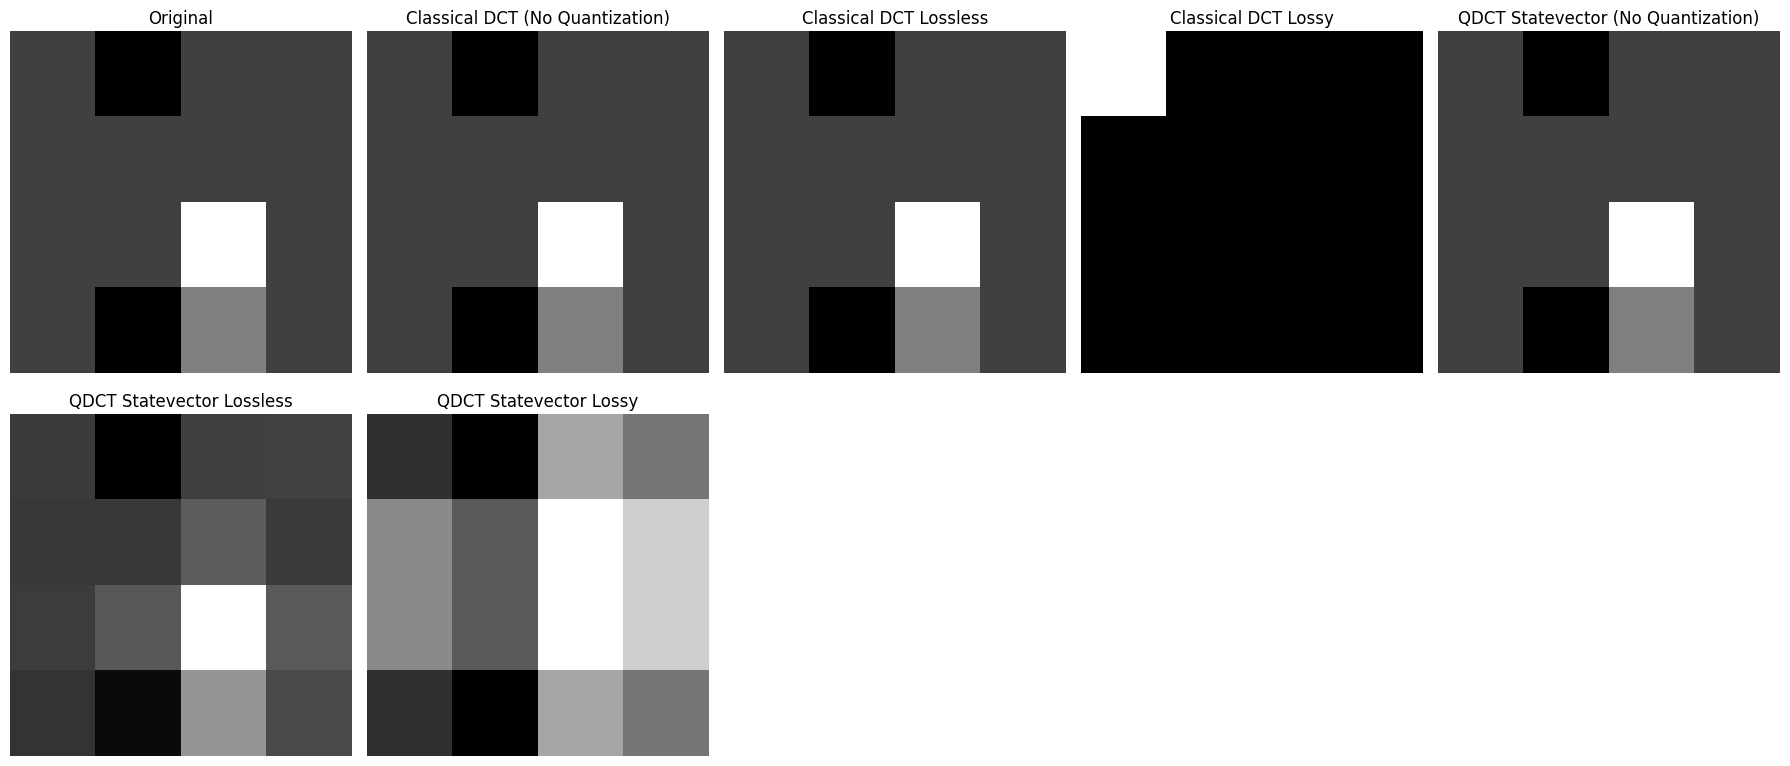

In [245]:
plt.figure(figsize=(18, 8))
for idx, (title, img) in enumerate(zip(titles, result_imgs_disp)):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.savefig("figure2.png", dpi=600, bbox_inches = 'tight')
plt.show()

In [246]:
images_dict = {
    "Original": result_imgs_disp[0],
    "Classical DCT (No Quantization)": result_imgs_disp[1],
    "Classical DCT Lossless (Quantization Float)": result_imgs_disp[2],
    "Classical DCT Lossy (Quantization + Rounding)": result_imgs_disp[3],
    "QDCT (No Quantization)": result_imgs_disp[4],
    "QDCT Lossless (Quantization Float)": result_imgs_disp[5],
    "QDCT Lossy (Factored Quantization + Rounding)": result_imgs_disp[6]
}

In [247]:
label_map = {
    "QDCT (No Quantization)": "QDCT - No Quant",
    "QDCT Lossless (Quantization Float)": "QDCT - Lossless",
    "QDCT Lossy (Factored Quantization + Rounding)": "QDCT - Lossy (Factored)",
    "Classical DCT (No Quantization)": "CDCT - No Quant",
    "Classical DCT Lossless (Quantization Float)": "CDCT - Lossless",
    "Classical DCT Lossy (Quantization + Rounding)": "CDCT - Lossy"
}

In [248]:
metrics_df4x4 = compute_metrics(images_dict["Original"], images_dict, psnr_plot_value=60)
metrics_df4x4["Label"] = metrics_df4x4["Image"].map(label_map)

print(metrics_df4x4)

                                           Image       PSNR  PSNR_plot  \
0                Classical DCT (No Quantization)  60.000000  60.000000   
1    Classical DCT Lossless (Quantization Float)  60.000000  60.000000   
2  Classical DCT Lossy (Quantization + Rounding)   8.085521   8.085521   
3                         QDCT (No Quantization)  60.000000  60.000000   
4             QDCT Lossless (Quantization Float)  25.173758  25.173758   
5  QDCT Lossy (Factored Quantization + Rounding)   9.826521   9.826521   

       SSIM  Compression Ratio                    Label  
0  1.000000           1.000000          CDCT - No Quant  
1  1.000000           1.000000          CDCT - Lossless  
2 -0.011360          14.000000             CDCT - Lossy  
3  1.000000           1.000000          QDCT - No Quant  
4  0.974705           0.933333          QDCT - Lossless  
5  0.544654           1.000000  QDCT - Lossy (Factored)  


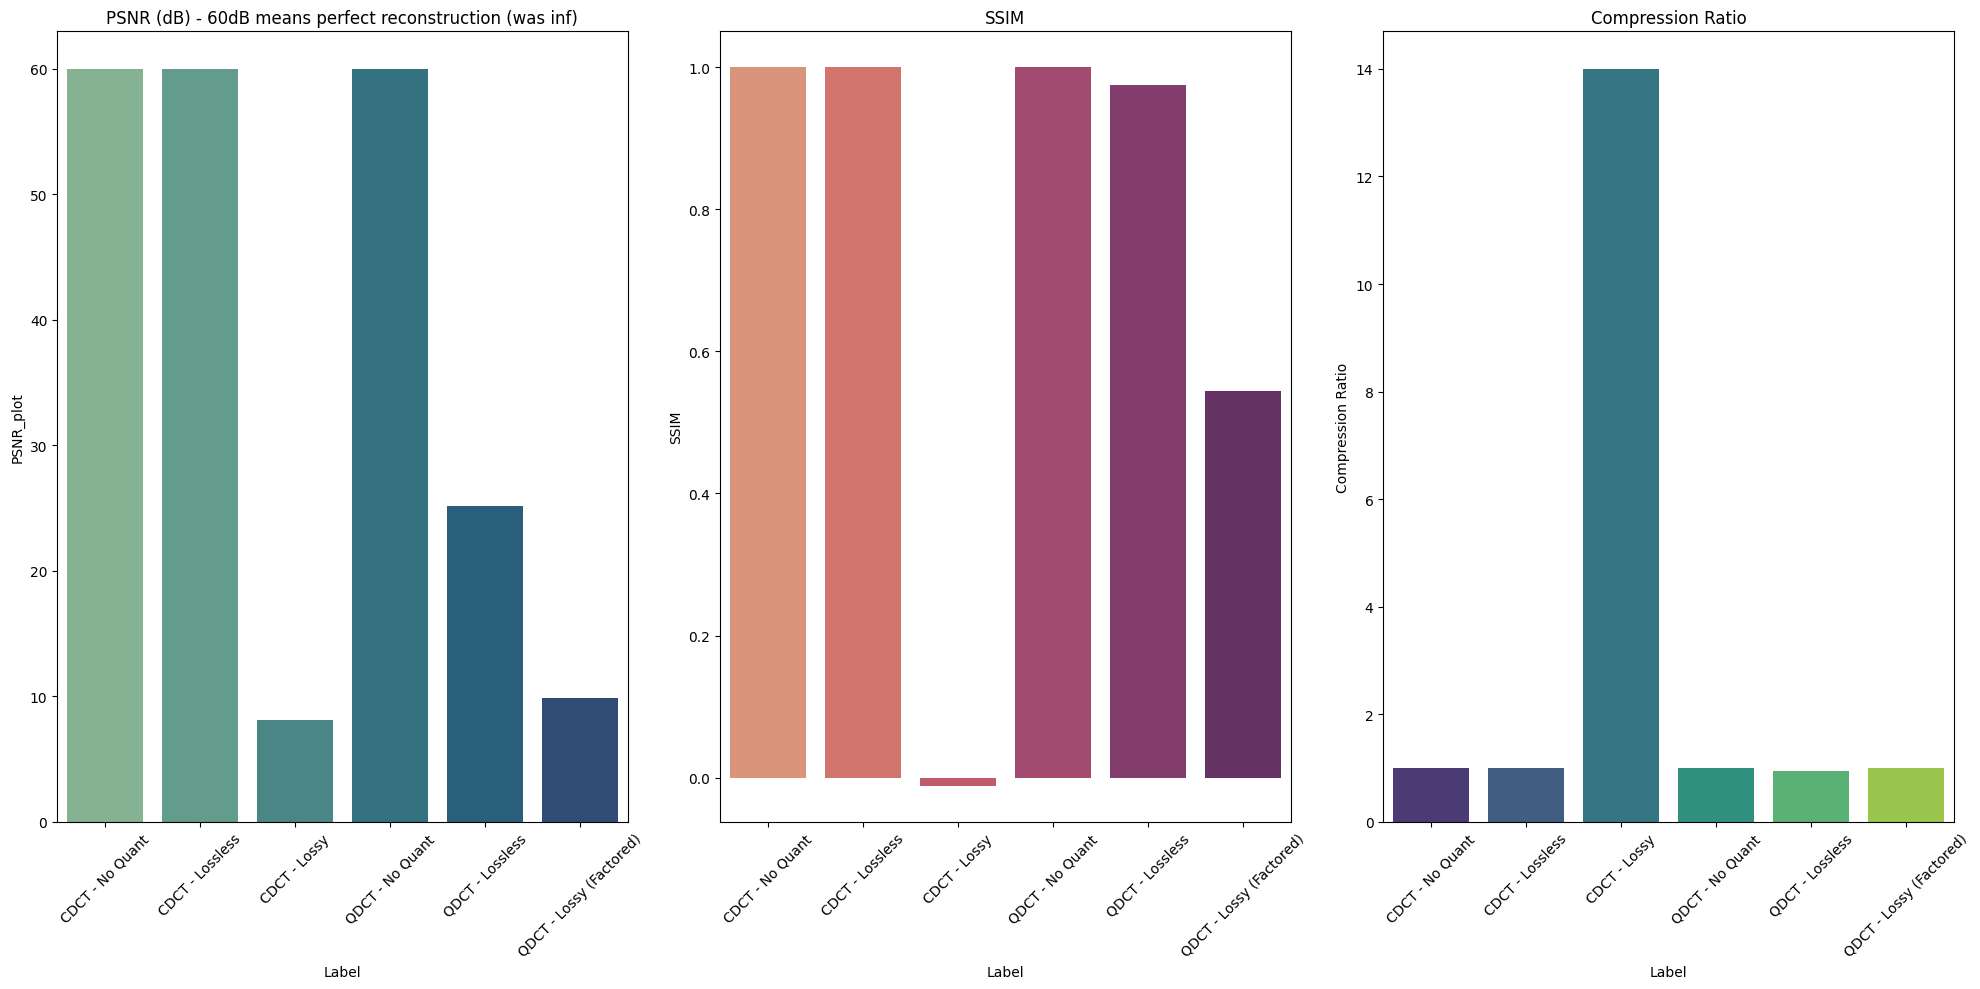

In [249]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.barplot(data=metrics_df4x4, x="Label", y="PSNR_plot", hue="Label", palette="crest", legend=False)
plt.xticks(rotation=45)
plt.title("PSNR (dB) - 60dB means perfect reconstruction (was inf)")

plt.subplot(1, 3, 2)
sns.barplot(data=metrics_df4x4, x="Label", y="SSIM", hue="Label", palette="flare", legend=False)
plt.xticks(rotation=45)
plt.title("SSIM")

plt.subplot(1, 3, 3)
sns.barplot(data=metrics_df4x4, x="Label", y="Compression Ratio", hue="Label", palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.title("Compression Ratio")

plt.tight_layout()
plt.show()

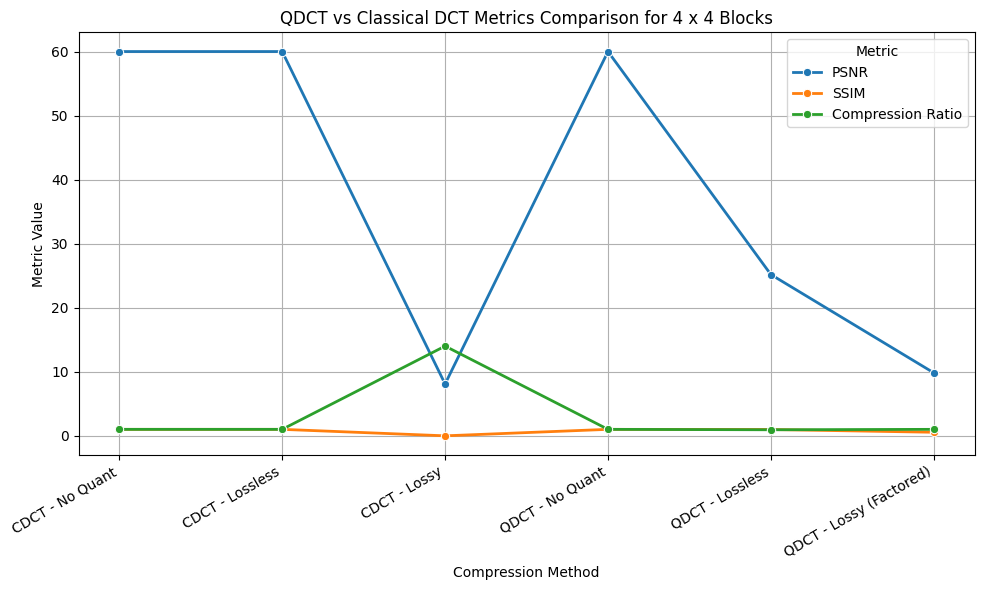

In [250]:
melted = metrics_df4x4.melt(id_vars="Label", 
                         value_vars=["PSNR", "SSIM", "Compression Ratio"],
                         var_name="Metric", 
                         value_name="Value")

plt.figure(figsize=(10, 6))
sns.lineplot(data=melted, x="Label", y="Value", hue="Metric", marker="o", linewidth=2)
plt.xticks(rotation=30, ha='right')
plt.title("QDCT vs Classical DCT Metrics Comparison for 4 x 4 Blocks")
plt.ylabel("Metric Value")
plt.xlabel("Compression Method")
plt.grid(True)
plt.tight_layout()
plt.show()

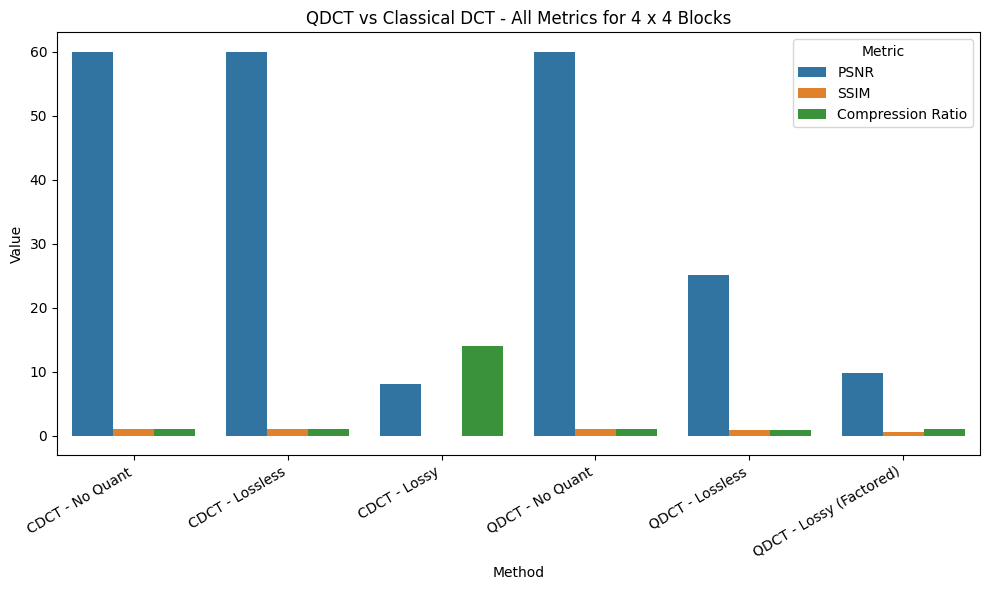

In [251]:
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Label", y="Value", hue="Metric")
plt.xticks(rotation=30, ha='right')
plt.title("QDCT vs Classical DCT - All Metrics for 4 x 4 Blocks")
plt.xlabel("Method")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

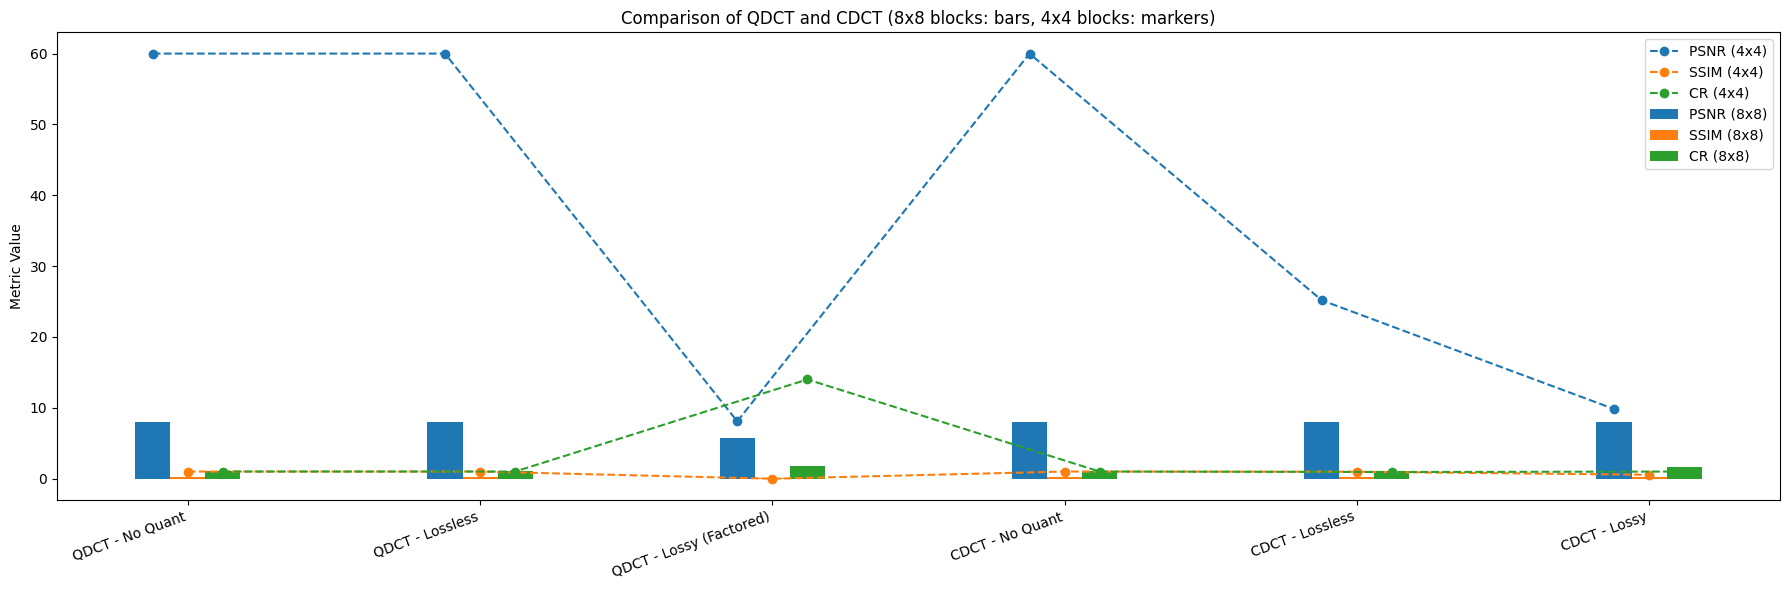

In [252]:
methods = metrics_df8x8['Label'].tolist()
x = np.arange(len(methods))
bar_width = 0.12
offset = [-bar_width, 0, bar_width] 

psnr_8x8 = metrics_df8x8["PSNR"].values
ssim_8x8 = metrics_df8x8["SSIM"].values
cr_8x8 = metrics_df8x8["Compression Ratio"].values

psnr_4x4 = metrics_df4x4["PSNR"].values
ssim_4x4 = metrics_df4x4["SSIM"].values
cr_4x4 = metrics_df4x4["Compression Ratio"].values

fig, ax = plt.subplots(figsize=(18, 6))

# 8x8 bars
ax.bar(x + offset[0], psnr_8x8, width=bar_width, label="PSNR (8x8)", color='C0')
ax.bar(x + offset[1], ssim_8x8, width=bar_width, label="SSIM (8x8)", color='C1')
ax.bar(x + offset[2], cr_8x8, width=bar_width, label="CR (8x8)", color='C2')

# 4x4 lines/markers (optional: use bars, or use lines/markers)
ax.plot(x + offset[0], psnr_4x4, 'o--', color='C0', label="PSNR (4x4)")
ax.plot(x + offset[1], ssim_4x4, 'o--', color='C1', label="SSIM (4x4)")
ax.plot(x + offset[2], cr_4x4, 'o--', color='C2', label="CR (4x4)")

ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=20, ha='right')
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of QDCT and CDCT (8x8 blocks: bars, 4x4 blocks: markers)")
ax.legend()
plt.tight_layout()
plt.savefig("figure3.png", dpi=600, bbox_inches = 'tight')
plt.show()

In [253]:
def pick_block(img, bs=8):
    H, W = img.shape
    best = (-1, -1, None, -np.inf)
    for i in range(0, H, bs):
        for j in range(0, W, bs):
            b = img[i:i+bs, j:j+bs].astype(float)
            v = float(np.var(b))
            if v > best[3]:
                best = (i, j, b, v)
    return best

In [254]:
i0, j0, block8, var8 = pick_block(image, 8)
print(f"Using block ({i0},{j0}), variance={var8:.4f}")
flat = block8.flatten()
norm = np.linalg.norm(flat)
amps = np.zeros_like(flat, dtype=float) if norm == 0 else flat / norm
if norm == 0: amps[0] = 1.0

Using block (32,64), variance=8508.3740


In [255]:
nq = 6
qc_qdct = QuantumCircuit(nq, name="QDCT-8x8")
qc_qdct.initialize(amps, range(nq))
qc_qdct.unitary(Operator(DCT8x8), range(nq), label="QDCT")


qc_iqdct = QuantumCircuit(nq, name="IDCT-8x8")
qc_iqdct.initialize(amps, range(nq))
qc_iqdct.unitary(Operator(IDCT8x8), range(nq), label="IDCT")

In [256]:
basis = ['rz', 'sx', 'x', 'cx', 'reset', 'measure']
qc_qdct_t = transpile(qc_qdct, basis_gates=basis, optimization_level=1)
qc_qdct_t = qc_qdct_t.decompose(reps=3)
qc_iqdct_t = transpile(qc_iqdct, basis_gates=basis, optimization_level=1)
qc_iqdct_t = qc_iqdct_t.decompose(reps=3)

print("QDCT depth:", qc_qdct_t.depth())
print("QDCT gate counts:", qc_qdct_t.count_ops())
print("IDCT depth:", qc_iqdct_t.depth())
print("IDCT gate counts:", qc_iqdct_t.count_ops())


QDCT depth: 12383
QDCT gate counts: OrderedDict({'u': 18598, 'cx': 1925, 'reset': 6})
IDCT depth: 12372
IDCT gate counts: OrderedDict({'u': 18585, 'cx': 1925, 'reset': 6})


In [257]:
fig_q = qc_qdct_t.draw(output='mpl', fold=60, idle_wires=False, scale=1.2)
fig_q.savefig("qdct_circuit_8x8.png", dpi=600, bbox_inches="tight")

fig_i = qc_iqdct_t.draw(output='mpl', fold=60, idle_wires=False, scale=1.2)
fig_i.savefig("iqdct_circuit_8x8.png", dpi=600, bbox_inches="tight")


MemoryError: std::bad_alloc